In [38]:
from autolearner.datasets import SpriteData, SpriteWithQuestions
from autolearner.model import *
from autolearner.config import *

In [39]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

train_data = SpriteWithQuestions("train", resolution = (64,64))
train_loader = DataLoader(train_data, batch_size = 3, shuffle= True)

for sample in train_loader:break;
print(sample["image"].shape)

torch.Size([3, 64, 64, 3])


{'program': ['exist(filter(scene(),Circle))', 'exist(filter(scene(),Circle))', 'exist(filter(scene(),Circle))'], 'answer': ['False', 'False', 'False']}
{'program': ['exist(filter(scene(),Cube))', 'exist(filter(scene(),Cube))', 'exist(filter(scene(),Cube))'], 'answer': ['True', 'False', 'True']}
{'program': ['exist(filter(scene(),Diamond))', 'exist(filter(scene(),Diamond))', 'exist(filter(scene(),Diamond))'], 'answer': ['True', 'True', 'False']}
{'program': ['count(scene())', 'count(scene())', 'count(scene())'], 'answer': ['2.0', '2.0', '2.0']}


[None, None, None, None]

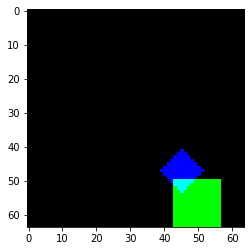

In [40]:
plt.imshow(sample["image"][0])

[print(b) for b in sample["question"]]

constuct a grid convolution model to test the utility of the grouping function $f(x)=\frac{\sum_i x_i^2}{\sum_i x_i}$. The model consists of 1) a grid convolution model that perform gridconv feature extraction 2) a instance tracking model that cluster pixel level information and form the whole. 3) a program executor that learns object centric representation and concept embeddings using query. Specificly, the grid-convolution model first takes the input image $x$ as input, then perform convolution and output the convolution feature denoted as $A_{l} = F(x_{l},\theta)$. Then we use $n$ pre-defined vector keys with same dimension as $A_l$ and use the dot product to calculate the raw mask of pixels. Specifically, the mask use calculated in the form of $m^i_l = \sigma( ( v^T_i \cdot A_l- \gamma) / \tau)$. With these masks over pixels, we use the grouping concreteness function $G(x)$ to perform concreteness evaluation over masks as $s_i = G(m^i_l)$. Then the object centric feature for each slot is calculated as the weighted mean over features of pixels.

In [41]:
from karanir.dklearn import ConvolutionBackbone, ConvolutionUnits

import math

def expat(tens, dim, num):
    rp_tens = tens.unsqueeze(dim)
    rp_shape = [1 for o in rp_tens.shape]
    rp_shape[dim] = num
    output_tensor = rp_tens.repeat(rp_shape)
    return output_tensor

def group_concrete(x, batch = True):
    assert x.min() >= 0.0,print("invalid x < 0.0",x)
    assert x.min() <= 1.0,print("invalid x > 1.0",x)
    if batch:
        x_square = x * x
        concrete_scores = x_square.sum(-1).sum(-1) / x.sum(-1).sum(-1)
        return concrete_scores
    return 

class NeuroGrouper(nn.Module):
    def __init__(self, n_slots = 4, feature_dim = 32):
        super().__init__()
        # [1] the Grid Convolution Model
        self.grid_conv = ConvolutionUnits(3 + 2, feature_dim, 128)

        # [2] the Instance Sort Model
        self.keys = nn.Parameter(torch.randn([n_slots, feature_dim]))

        # [3] Neuro-Symolic Executor
        self.executor = SceneProgramExecutor(config)
    
    def forward(self, im):
        outputs = {}

        B, W, H, C = im.shape
        im = im.permute(0,3,1,2) #BxCxWxH

        x,y = torch.meshgrid([torch.linspace(-1,1,W),torch.linspace(-1,1,H)])
        #print(x.shape, y.shape)
        im = torch.cat([im,expat(x.unsqueeze(0),0,B),expat(y.unsqueeze(0),0,B)], dim = 1)
 
        grid_feature = self.grid_conv(im) #BxDxWxH
        key_feature = expat(self.keys,0,B) # BxNxD

        # [Calculate Mask Over]
        raw_masks = torch.einsum("bnd,bdwh->bnwh",key_feature, grid_feature)/ (math.sqrt(W*H))
        masks = torch.softmax(raw_masks + 1e-6, dim = 1) # [BNWH]
        B, N, W, H = masks.shape

        scores = group_concrete(masks)
        
        #scores = masks.max(dim = -1).values.max(dim = -1).values

        outputs["scores"] = scores
        outputs["masks"] = masks

        masked_features = expat(grid_feature.permute(0,2,3,1), 1, N) * masks.unsqueeze(-1)
        outputs["features"] = torch.mean(torch.mean(masked_features,dim = -2), dim = -2)

        return outputs



In [42]:
# [Train the Segmentation Modle]
from tqdm import tqdm
def train(model, dataset, epochs = 100, ckpt_itrs = 20):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    train_loader = DataLoader(dataset, batch_size = 1, shuffle= True)
    itr = 0
    optimizer = torch.optim.Adam(model.parameters(), lr = 2e-4)
    for epoch in tqdm(range(epochs)):
        for sample in train_loader:
            outputs = model(sample["image"].to(device))

            masks = outputs["masks"]
            B, N, W, H = masks.shape
            scores = outputs["scores"]
            features = outputs["features"]

            loss = 0.0

            qa_pairs = sample["question"]

            for b in range(B):
                for i,qa_pair in enumerate(qa_pairs):  
                    programs = qa_pair["program"]
                    answers = qa_pair["answer"]              
                    kwargs = {
                    "end":[scores[b]],
                    "features":[features[b]]}

                    q = model.executor.parse(programs[b])
                    o = model.executor(q,**kwargs)
                    ans = answers[b]
                    
                    if ans in ["True","False"]:
                        if itr % ckpt_itrs == 0:print(q,o["end"].sigmoid().detach().numpy(),ans)
                        if ans == "True":
                            loss -= torch.log(torch.sigmoid(o["end"]))
                        else: loss -=  torch.log(1 - torch.sigmoid(o["end"]))
                    else:
                        if itr % ckpt_itrs == 0:print(q,o["end"].detach().numpy()-1, float(answers[b]))
                        loss += torch.nn.functional.mse_loss(torch.tensor(float(answers[b])), o["end"]) * 1.0


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if itr % ckpt_itrs == 0:
                masks = outputs["masks"].detach()
                scores = outputs["scores"].detach() # [BxN]
                B, N, W, H = masks.shape
                plt.figure("masks")
                for b in range(B):
                    for n in range(N):
                        plt.subplot(B,N,N * b + n + 1);plt.cla()
                        plt.imshow(masks[b,n,:,:].unsqueeze(-1) * sample["image"][b,:,:,:].numpy(), cmap="bone")
                plt.figure("scores")
                for b in range(B):
                    plt.subplot(B,1,b+1); plt.cla()
                    plt.bar(list(range(len(scores[b]))),scores[b])
                print("Loss:",loss.detach().numpy())
            plt.show()
            itr += 1

    

  0%|          | 0/10000 [00:00<?, ?it/s]

Exist(Filter(Scene(), Circle)) 0.09481725 False
Exist(Filter(Scene(), Cube)) 0.043533523 True
Exist(Filter(Scene(), Diamond)) 0.06943559 False
Count(Scene()) 2.5033950805664062e-06 2.0
Loss: 4.3058014


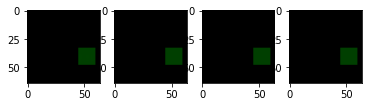

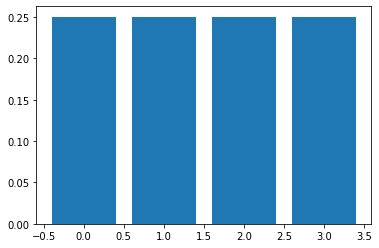

Exist(Filter(Scene(), Circle)) 0.5686007 True
Exist(Filter(Scene(), Cube)) 0.72340256 True
Exist(Filter(Scene(), Diamond)) 0.6833284 True
Count(Scene()) 0.8977535963058472 2.0
Loss: 1.2796003


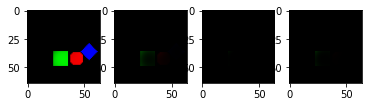

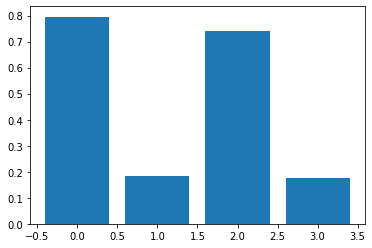

Exist(Filter(Scene(), Circle)) 0.66351146 True
Exist(Filter(Scene(), Cube)) 0.7260972 False
Exist(Filter(Scene(), Diamond)) 0.66031367 True
Count(Scene()) 1.1297929286956787 2.0
Loss: 2.1370778


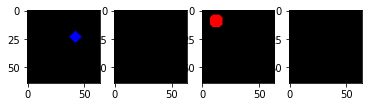

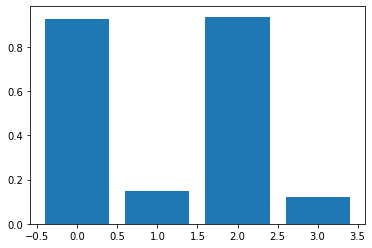

  0%|          | 1/10000 [00:55<154:20:36, 55.57s/it]

Exist(Filter(Scene(), Circle)) 0.53878003 True
Exist(Filter(Scene(), Cube)) 0.6770025 True
Exist(Filter(Scene(), Diamond)) 0.74647534 True
Count(Scene()) 1.1236300468444824 2.0
Loss: 1.3162054


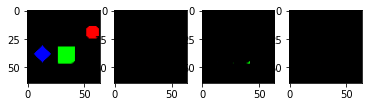

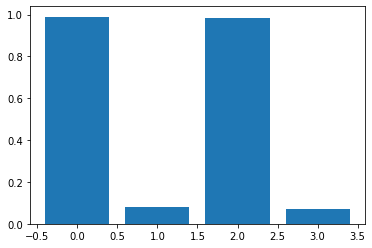

Exist(Filter(Scene(), Circle)) 0.728713 True
Exist(Filter(Scene(), Cube)) 0.64102715 True
Exist(Filter(Scene(), Diamond)) 0.6480528 True
Count(Scene()) 1.0160129070281982 2.0
Loss: 1.1951983


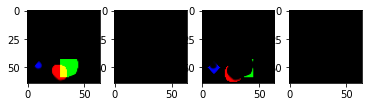

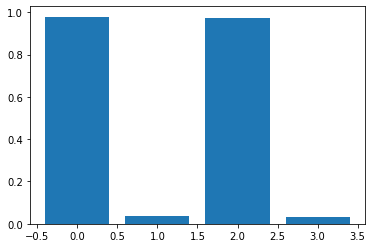

  0%|          | 2/10000 [01:49<151:06:04, 54.41s/it]

Exist(Filter(Scene(), Circle)) 0.7984614 True
Exist(Filter(Scene(), Cube)) 0.7528711 True
Exist(Filter(Scene(), Diamond)) 0.61697906 False
Count(Scene()) 1.0178709030151367 2.0
Loss: 1.4689149


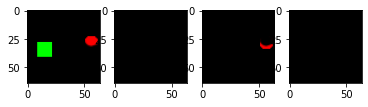

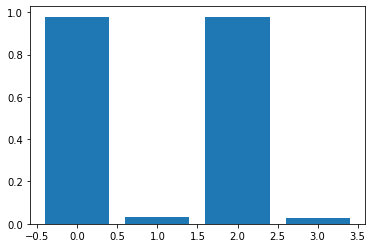

Exist(Filter(Scene(), Circle)) 0.69618297 True
Exist(Filter(Scene(), Cube)) 0.6128159 True
Exist(Filter(Scene(), Diamond)) 0.64908355 True
Count(Scene()) 0.9997422695159912 2.0
Loss: 1.2840275


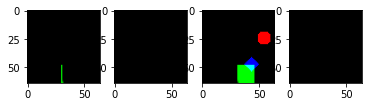

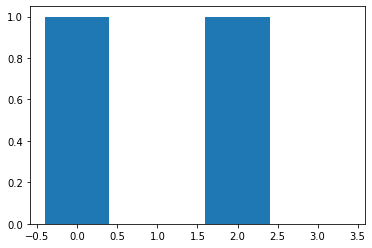

Exist(Filter(Scene(), Circle)) 0.67371964 False
Exist(Filter(Scene(), Cube)) 0.67991024 True
Exist(Filter(Scene(), Diamond)) 0.5746944 True
Count(Scene()) 0.999947190284729 2.0
Loss: 2.0597098


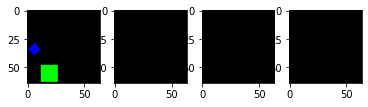

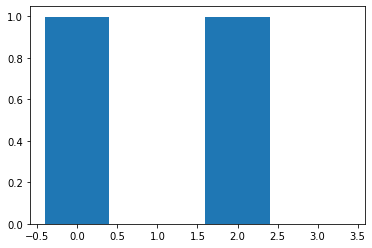

  0%|          | 3/10000 [02:44<152:39:36, 54.97s/it]

Exist(Filter(Scene(), Circle)) 0.65086514 False
Exist(Filter(Scene(), Cube)) 0.695005 True
Exist(Filter(Scene(), Diamond)) 0.67879647 True
Count(Scene()) 1.000657558441162 2.0
Loss: 1.8035676


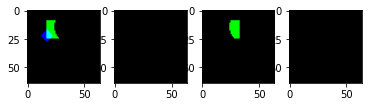

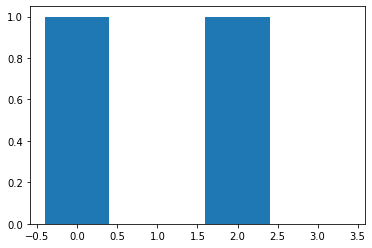

Exist(Filter(Scene(), Circle)) 0.6933255 True
Exist(Filter(Scene(), Cube)) 0.5571792 False
Exist(Filter(Scene(), Diamond)) 0.6632245 False
Count(Scene()) 1.0009329319000244 2.0
Loss: 2.2691855


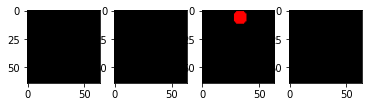

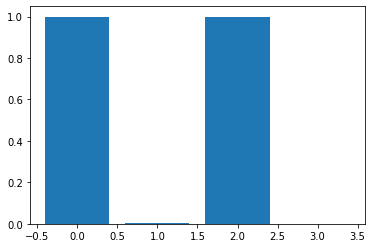

  0%|          | 4/10000 [03:37<149:43:49, 53.92s/it]

Exist(Filter(Scene(), Circle)) 0.5930108 True
Exist(Filter(Scene(), Cube)) 0.7200062 True
Exist(Filter(Scene(), Diamond)) 0.73069984 True
Count(Scene()) 0.9983506202697754 2.0
Loss: 1.1647934


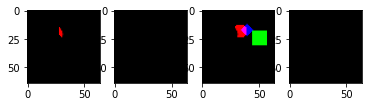

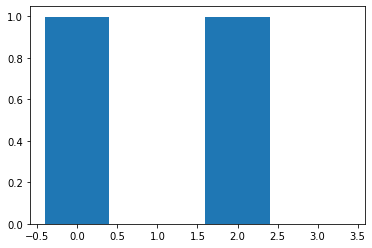

Exist(Filter(Scene(), Circle)) 0.8441076 False
Exist(Filter(Scene(), Cube)) 0.64817256 True
Exist(Filter(Scene(), Diamond)) 0.6837164 False
Count(Scene()) 0.9961135387420654 2.0
Loss: 3.4433186


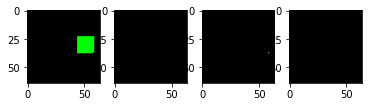

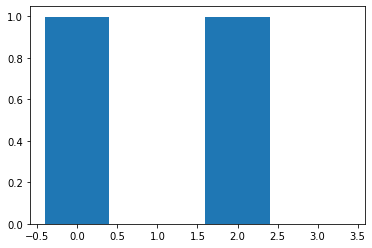

  0%|          | 4/10000 [04:07<171:50:07, 61.89s/it]

invalid x < 0.0 tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, 

AssertionError: None

In [43]:
config.domain = "sprites"
config.concept_dim = 32
config.concept_type = "cone"
config.temperature = 0.2
grouper = NeuroGrouper(4, config.concept_dim )
train(grouper, train_data, 10000, 200)